# Incorporating Recent COVID19 Trends to Construct a Machine Learning for Stock Market Prediction

The end goal of my project is to create a machine learning model that forecasts future trends in the stock market. Given the volatility of the market in the status quo, incorporating input data related to covid19 is essential for any successful predictions.

There are a number of moving parts to this ambitious project:
First, gathering and compiling train / test data. There are three data sources that I will initially be using:
1. Aggregate coronavirus statistics - downloaded from Kaggle, required some preprocessing (aggregating total cases among countries) -- this includes confirmed cases, deaths, and recovered patients. Input data is a function of percent change in each of these categories. The thinking behind including this data source is that large jumps in deaths, recoveries, or cases on certain days may influence investor perception of the crisis and subsequently their investment decisions. 

2. Sentiment analysis - sentiment analysis of the news. Used the Google News API in order to gather news stories relating to the stock market everyday. Then used the Google Cloud Natural Language API to analyze sentiments for news headlines.

3. Technical indicators - using the Alphavantage API in order to gather technical indicators (RSI, MACD, SMA, etc.) that will be used as well. 

Second, use train / test machine learning models in order to identify the best performing ones. 

## SETUP

In [4]:
!pip install newsapi-python

  Using cached https://files.pythonhosted.org/packages/de/9e/9050199ac7cbc755d1c49577fdaa5517901124b574264b3602a8b8028440/newsapi_python-0.2.6-py2.py3-none-any.whl


In [77]:
import requests
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import matplotlib 
from matplotlib import pyplot as plt
import google.datalab.storage as storage
import pandas as pd
from newsapi.newsapi_client import NewsApiClient
import os
from datetime import date, timedelta
from datetime import datetime
from dateutil.rrule import rrule, DAILY

from io import BytesIO
import numpy as np
import googleapiclient.discovery

from alpha_vantage.techindicators import TechIndicators
from sklearn import preprocessing
import statsmodels.api as sm

## Exploring Alphavantage and Selecting a Target Variable

In [132]:
AV_API_KEY = "LBTZOMI8UAQDHHRK"
OPEN = "1. open"
HIGH = "2. high"
LOW = "3. low"
CLOSE = "4. close"
VOLUME = "5. volume"

ts = TimeSeries(key=AV_API_KEY, output_format='pandas')
data_dow, meta_data_dow = ts.get_daily(symbol='DJI', outputsize='compact')
data_sp, meta_data_sp = ts.get_daily(symbol='INX',outputsize='compact')

data_sp.head()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [11]:

#dependent variable -- percent change from previous close 

data_dow = data_dow.loc['2020-01-01':'2020-03-27']
data_sp = data_sp.loc['2020-01-01':'2020-03-27']

data_dow[CLOSE] = data_dow[CLOSE].pct_change()
data_sp[CLOSE] = data_sp[CLOSE].pct_change()

data_dow = data_dow[data_dow[CLOSE] <= 100]
data_sp = data_sp[data_sp[CLOSE] <= 100]

data_dow = data_dow.dropna(axis=0)
data_sp = data_sp.dropna(axis=0)


In [12]:

data_dow[CLOSE].head()
#data_sp[CLOSE]

date
2020-01-03   -0.008103
2020-01-06    0.002392
2020-01-07   -0.004170
2020-01-08    0.005647
2020-01-09    0.007369
Name: 4. close, dtype: float64

## COVID DATA

In [13]:
%gcs read --object gs://covid19-data-3-28/covid_19_data.csv --variable   csv_as_bytes


In [14]:
covid_df = pd.read_csv(BytesIO(csv_as_bytes))

In [15]:
covid_df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [16]:
covid_df["ObservationDate"] = pd.to_datetime(covid_df['ObservationDate'])
uq_dates = covid_df.ObservationDate.unique()


temp = []
for date in uq_dates:
  row = covid_df.loc[covid_df['ObservationDate']==date][["Confirmed","Deaths","Recovered"]]
  confirmed = row["Confirmed"].sum()
  deaths = row["Deaths"].sum()
  recovered = row["Recovered"].sum()
  temp.append([confirmed,deaths,recovered])
  
covid_df_clean = pd.DataFrame(temp, columns=["Confirmed","Deaths","Recovered"], index=uq_dates)

covid_df_clean.head()

,Confirmed,Deaths,Recovered
2020-01-22,555.0,17.0,28.0
2020-01-23,653.0,18.0,30.0
2020-01-24,941.0,26.0,36.0
2020-01-25,1438.0,42.0,39.0
2020-01-26,2118.0,56.0,52.0


In [17]:
covid_df_clean["Confirmed"] = covid_df_clean["Confirmed"].pct_change()
covid_df_clean["Deaths"] = covid_df_clean["Deaths"].pct_change()
covid_df_clean["Recovered"] = covid_df_clean["Recovered"].pct_change()

In [131]:
covid_df_clean.to_csv('covid_df_clean.csv')

## NEWS SENTIMENT ANALYSIS

In [134]:
newsapi = NewsApiClient(api_key='2595fef996844d06b459ef0c79862196')
all_articles = newsapi.get_everything(q='stocks & DJI',
                                      from_param='2020-02-29',
                                      to='2020-02-29',
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)
print(all_articles)

{'articles': [{'publishedAt': '2020-02-29T00:37:20Z', 'url': 'https://www.firstpost.com/business/wall-st-bounce-to-little-to-late-as-world-stocks-post-shock-weekly-decline-8100291.html', 'description': 'By Rodrigo Campos NEW YORK (Reuters) - Coronavirus panic sent world stock markets tumbling again on Friday, with an index of global stocks setting its largest weekly fall since the 2008 global financial crisis, and over $5 trillion wiped from global market va…', 'urlToImage': 'https://images.firstpost.com/wp-content/uploads/reuters/02-2020/29/2020-02-28T202929Z_1_LYNXNPEG1R20O_RTROPTP_2_USA-STOCKS.jpg', 'author': 'Reuters', 'source': {'name': 'Firstpost.com', 'id': None}, 'title': 'Wall St. bounce to little, to late as world stocks post shock weekly decline', 'content': 'By Rodrigo Campos\r\nNEW YORK (Reuters) - Coronavirus panic sent world stock markets tumbling again on Friday, with an index of global stocks setting its largest weekly fall since the 2008 global financial crisis, and o

In [19]:
def analyze_sentiment(text, encoding='UTF32'):
    body = {
        'document': {
            'type': 'PLAIN_TEXT',
            'content': text,
        },
        'encoding_type': encoding
    }

    service = googleapiclient.discovery.build('language', 'v1')

    request = service.documents().analyzeSentiment(body=body)
    response = request.execute()

    return response

In [25]:
a = date(2020, 2, 29)
b = date(2020, 3, 27)
sentiments = {}
for dt in rrule(DAILY, dtstart=a, until=b):
    str_date = str(dt.strftime("%Y-%m-%d"))
    all_articles = newsapi.get_everything(q='stocks',
                                      from_param=str_date,
                                      to=str_date,
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)
    headlines = ""
    for a in all_articles['articles']:
        if isinstance(a["title"], str): 
            headlines += a["title"]
    sentiments[dt] = analyze_sentiment(headlines)['documentSentiment']

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


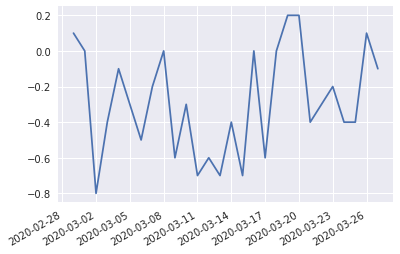

In [26]:
sentiment_df = pd.DataFrame(list(sentiments.values()), columns=["magnitude","score"], index=sentiments.keys())
sentiment_df["score"].plot()

## TECHNICAL INDICATORS

In [27]:
#technical indicators to act as input data for the model

TI=TechIndicators(key=AV_API_KEY,output_format='pandas')

rsi_data_dow, meta_data = TI.get_rsi(symbol='DJI',interval='daily',time_period=14)
macd_data_dow, meta_data = TI.get_macd(symbol='DJI',interval='daily')
sma_data_dow, meta_data = TI.get_sma(symbol='DJI',time_period=30)
bbands_data_dow, meta_data = TI.get_bbands(symbol='DJI')

In [30]:
rsi_data_sp, meta_data = TI.get_rsi(symbol='INX',interval='daily',time_period=14)
macd_data_sp, meta_data = TI.get_macd(symbol='INX',interval='daily')
sma_data_sp, meta_data = TI.get_sma(symbol='INX',time_period=30)
bbands_data_sp, meta_data = TI.get_bbands(symbol='INX')

## COMPILING / PREPROCESSING DATA FOR ML

This uses all available data sources and therefore only has 30 days of past data -- other models will be tested with a greater number of rows

In [29]:
input_data_dow = pd.DataFrame(columns=["Volume","Price_Change"],index=uq_dates)
input_data_dow["Volume"] = data_dow[VOLUME]
input_data_dow["Price_Change"] = data_dow[CLOSE]
input_data_dow = input_data_dow.merge(rsi_data_dow,left_index=True,right_index=True)
input_data_dow = input_data_dow.merge(sma_data_dow,left_index=True,right_index=True)
input_data_dow = input_data_dow.merge(macd_data_dow,left_index=True,right_index=True)
input_data_dow = input_data_dow.merge(bbands_data_dow,left_index=True,right_index=True)
input_data_dow = input_data_dow.merge(covid_df_clean,left_index=True,right_index=True)
input_data_dow = input_data_dow.merge(sentiment_df,left_index=True,right_index=True)


In [31]:
input_data_sp = pd.DataFrame(columns=["Volume","Price_Change"],index=uq_dates)
input_data_sp["Volume"] = data_sp[VOLUME]
input_data_sp["Price_Change"] = data_sp[CLOSE]
input_data_sp = input_data_sp.merge(rsi_data_sp,left_index=True,right_index=True)
input_data_sp = input_data_sp.merge(sma_data_sp,left_index=True,right_index=True)
input_data_sp = input_data_sp.merge(macd_data_sp,left_index=True,right_index=True)
input_data_sp = input_data_sp.merge(bbands_data_sp,left_index=True,right_index=True)
input_data_sp = input_data_sp.merge(covid_df_clean,left_index=True,right_index=True)
input_data_sp = input_data_sp.merge(sentiment_df,left_index=True,right_index=True)
input_data_sp.head()

,Volume,Price_Change,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band,Confirmed,Deaths,Recovered,magnitude,score
2020-03-02,6.376400e+09,0.046039,37.3711,3275.1606,-41.5219,-18.1586,-59.6805,2565.8794,2591.7055,2617.5316,0.021930,0.029706,0.067563,1.7,-0.8
2020-03-03,6.355940e+09,-0.028108,32.3586,3264.2856,-40.3604,-28.2487,-68.6091,2561.9278,2590.2075,2618.4872,0.028070,0.024311,0.057607,0.8,-0.4
2020-03-04,5.035480e+09,0.042203,44.1342,3257.9300,-29.1702,-35.5413,-64.7115,2555.8860,2588.0871,2620.2883,0.024557,0.029747,0.061001,0.5,-0.1
2020-03-05,5.575550e+09,-0.033922,38.1436,3248.0030,-27.0794,-42.3111,-69.3905,2552.6383,2585.1972,2617.7561,0.029036,0.028888,0.051318,1.1,-0.3
2020-03-06,6.552140e+09,-0.017054,35.6150,3236.2306,-27.2547,-49.1248,-76.3795,2549.6183,2582.7896,2615.9609,0.039985,0.033453,0.038459,0.5,-0.5


In [32]:
#normalize between -1 and 1

input_data_dow = input_data_dow.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
input_data_dow.head()

,Volume,Price_Change,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band,Confirmed,Deaths,Recovered,magnitude,score
2020-03-02,-0.184214,0.234033,0.057641,0.413583,-0.052607,0.519103,0.491111,0.523811,0.449528,0.235681,-0.489552,-0.480511,0.443716,0.342105,-0.49
2020-03-03,-0.162291,-0.096764,-0.161067,0.386010,-0.034729,0.464413,0.444881,0.482376,0.427904,0.267285,-0.435167,-0.524597,0.259158,-0.131579,-0.09
2020-03-04,-0.582753,0.210781,0.389663,0.369091,0.107869,0.425790,0.470302,0.467629,0.412950,0.252362,-0.466283,-0.480180,0.322069,-0.289474,0.21
2020-03-05,-0.538863,-0.122941,0.121107,0.344457,0.136806,0.390426,0.448173,0.437421,0.385340,0.232692,-0.426615,-0.487202,0.142569,0.026316,0.01
2020-03-06,-0.267245,-0.016030,0.057237,0.317972,0.155304,0.357147,0.423446,0.406656,0.354722,0.203646,-0.329631,-0.449897,-0.095812,-0.289474,-0.19


In [33]:
input_data_sp = input_data_dow.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
input_data_sp.head()

,Volume,Price_Change,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band,Confirmed,Deaths,Recovered,magnitude,score
2020-03-02,-0.184214,0.234033,0.057641,0.413583,-0.052607,0.519103,0.491111,0.523811,0.449528,0.235681,-0.489552,-0.480511,0.443716,0.342105,-0.49
2020-03-03,-0.162291,-0.096764,-0.161067,0.386010,-0.034729,0.464413,0.444881,0.482376,0.427904,0.267285,-0.435167,-0.524597,0.259158,-0.131579,-0.09
2020-03-04,-0.582753,0.210781,0.389663,0.369091,0.107869,0.425790,0.470302,0.467629,0.412950,0.252362,-0.466283,-0.480180,0.322069,-0.289474,0.21
2020-03-05,-0.538863,-0.122941,0.121107,0.344457,0.136806,0.390426,0.448173,0.437421,0.385340,0.232692,-0.426615,-0.487202,0.142569,0.026316,0.01
2020-03-06,-0.267245,-0.016030,0.057237,0.317972,0.155304,0.357147,0.423446,0.406656,0.354722,0.203646,-0.329631,-0.449897,-0.095812,-0.289474,-0.19


## Multiple Linear Regression

In [34]:
X_dow = input_data_dow.drop('Price_Change', axis=1)
y_dow = input_data_dow["Price_Change"]

X_dow = sm.add_constant(X_dow)
mlr = sm.OLS(y_dow, X_dow).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price_Change   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     4.318
Date:                Sun, 29 Mar 2020   Prob (F-statistic):             0.0577
Time:                        13:36:40   Log-Likelihood:                 23.948
No. Observations:                  20   AIC:                            -17.90
Df Residuals:                       5   BIC:                            -2.961
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                     0      0.033          0      1.000      -0.084       0.084
Volume               0.2345      0.338      0.694      0.519      -0.635       1.104
RSI                  1.3718      0.411      3.341      0.021       0.316       2.427
SMA                 -2.0424     10.799     -0.189      0.857     -29.803      25.719
MACD_Hist         1.266e+06   8.17e+05      1.548      0.182   -8.36e+05    3.37e+06
MACD_Signal       2.808e+06   1.81e+06      1.548      0.182   -1.85e+06    7.47e+06
MACD             -2.833e+06   1.83e+06     -1.548      0.182   -7.54e+06    1.87e+06
Real Lower Band  -1.244e+07   8.15e+06     -1.526      0.188   -3.34e+07    8.51e+06
Real Middle Band  1.696e+07   1.11e+07      1.526      0.188   -1.16e+07    4.55e+07
Real Upper Band  -4.703e+06   3.08e+06     -1.526      0.188   -1.26e+07    3.22e+06
Confirmed            0.2956      0.486      0.609      0.569      -0.953       1.544
Deaths               0.0684      0.514      0.133      0.899      -1.252       1.389
Recovered            0.0472      0.370      0.128      0.904      -0.904       0.999
magnitude           -0.2975      0.233     -1.278      0.257      -0.896       0.301
score               -0.5002      0.211     -2.373      0.064      -1.042       0.042
==============================================================================
Omnibus:                        0.144   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.931   Jarque-Bera (JB):                0.336
Skew:                          -0.138   Prob(JB):                        0.845
Kurtosis:                       2.427   Cond. No.                     4.33e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

WOW! An R-squared value of 0.906 -- that looks promising. However, our F-statistic is really really low so the next step is going to be getting rid of features with a high p-value. Two surprising features are sentiment score and Recovered -- they both have interestingly low p-values. Lets see some plots to help improve the model even more.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


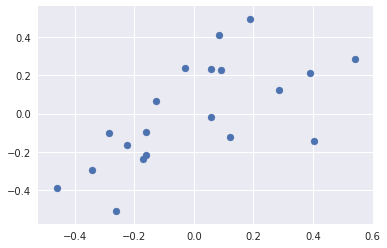

In [35]:
plt.scatter(input_data_dow['RSI'],input_data_dow['Price_Change'])

In [36]:
X_dow = input_data_dow.drop(['Price_Change','SMA','MACD_Hist','MACD_Signal','Confirmed','Deaths','magnitude'], axis=1)

X_dow = sm.add_constant(X_dow)
mlr = sm.OLS(y_dow, X_dow).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price_Change   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     8.950
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           0.000738
Time:                        13:36:55   Log-Likelihood:                 18.392
No. Observations:                  20   AIC:                            -18.78
Df Residuals:                      11   BIC:                            -9.823
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                     0      0.029          0      1.000      -0.064       0.064
Volume               0.1807      0.269      0.671      0.516      -0.412       0.773
RSI                  1.3141      0.223      5.888      0.000       0.823       1.805
MACD                -2.6723      0.647     -4.131      0.002      -4.096      -1.248
Real Lower Band  -9.321e+06   6.19e+06     -1.506      0.160   -2.29e+07     4.3e+06
Real Middle Band  1.271e+07   8.44e+06      1.506      0.160   -5.87e+06    3.13e+07
Real Upper Band  -3.525e+06   2.34e+06     -1.506      0.160   -8.68e+06    1.63e+06
Recovered           -0.1194      0.205     -0.581      0.573      -0.571       0.333
score               -0.4471      0.166     -2.686      0.021      -0.813      -0.081
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   2.647
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.428
Skew:                          -0.347   Prob(JB):                        0.807
Kurtosis:                       2.818   Cond. No.                     3.69e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model seems more promising. Though it has a lower R squared value, it's more robust because the correalted features have been removed and our F statistic is higher. Now let's try the same thing with the S&P index. 

In [38]:
X_sp = input_data_sp.drop(['Price_Change','SMA','MACD_Hist','MACD_Signal','Confirmed','Deaths','magnitude'], axis=1)
y_sp = input_data_sp['Price_Change']
X_sp = sm.add_constant(X_sp)
mlr = sm.OLS(y_sp, X_sp).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price_Change   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     8.950
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           0.000738
Time:                        13:37:34   Log-Likelihood:                 18.392
No. Observations:                  20   AIC:                            -18.78
Df Residuals:                      11   BIC:                            -9.823
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                     0      0.029          0      1.000      -0.064       0.064
Volume               0.1807      0.269      0.671      0.516      -0.412       0.773
RSI                  1.3141      0.223      5.888      0.000       0.823       1.805
MACD                -2.6723      0.647     -4.131      0.002      -4.096      -1.248
Real Lower Band  -9.321e+06   6.19e+06     -1.506      0.160   -2.29e+07     4.3e+06
Real Middle Band  1.271e+07   8.44e+06      1.506      0.160   -5.87e+06    3.13e+07
Real Upper Band  -3.525e+06   2.34e+06     -1.506      0.160   -8.68e+06    1.63e+06
Recovered           -0.1194      0.205     -0.581      0.573      -0.571       0.333
score               -0.4471      0.166     -2.686      0.021      -0.813      -0.081
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   2.647
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.428
Skew:                          -0.347   Prob(JB):                        0.807
Kurtosis:                       2.818   Cond. No.                     3.69e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

As expected, similar if not almost identical results! Considering the graph we saw earlier indicating the S&P and Dow moved together very closely as of late, this makes a lot of sense. 

## AutoML!
For the next part of this project, I'll be uploading some more data to Google Cloud Storage, and then be running AutoML Tables on it.

First, I'll try and do this for long term stock prediction. Then I'll do it over the past 30 days. Finally I'll try and construct a ML model in python that uses both data sources in one unified manner!

In [39]:
data_dow_long, meta_data_dow = ts.get_daily(symbol='DJI', outputsize='full')
data_sp_long, meta_data_sp = ts.get_daily(symbol='INX',outputsize='full')


In [40]:
data_dow_long.head()

,2. high,3. low,1. open,5. volume,4. close
date,,,,,
2000-01-03,11522.0098,11305.6904,11501.8496,169750000.0,11357.5098
2000-01-04,11350.0596,10986.4502,11349.7500,178420000.0,10997.9297
2000-01-05,11215.0996,10938.6699,10989.3701,203190000.0,11122.6504
2000-01-06,11313.4502,11098.4502,11113.3701,176550000.0,11253.2598
2000-01-07,11528.1396,11239.9199,11247.0596,184900000.0,11522.5596


In [41]:
#made a real quick decision to just stick with the dow for this part - it's becoming tedious to also work with S&P for no real reason

data_dow_long = data_dow_long.merge(rsi_data_dow,left_index=True,right_index=True)
data_dow_long = data_dow_long.merge(sma_data_dow,left_index=True,right_index=True)
data_dow_long = data_dow_long.merge(macd_data_dow,left_index=True,right_index=True)
data_dow_long = data_dow_long.merge(bbands_data_dow,left_index=True,right_index=True)

data_dow_long = data_dow_long.drop([LOW,HIGH,OPEN],axis=1)
data_dow_long.head()

,5. volume,4. close,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band
date,,,,,,,,,,
2000-02-18,208930000.0,10219.5195,31.2308,11036.0073,-14.7959,-255.3512,-270.1471,10314.6407,10798.2390,11281.8372
2000-02-22,194340000.0,10304.8398,34.5216,10995.4166,-16.1996,-259.4011,-275.6007,10244.6182,10763.0725,11281.5268
2000-02-23,185280000.0,10225.7305,32.9473,10950.5343,-18.9138,-264.1296,-283.0434,10169.8391,10722.8645,11275.8899
2000-02-24,237540000.0,10092.6299,30.4327,10903.2526,-25.7097,-270.5570,-296.2667,10078.1861,10675.8465,11273.5068
2000-02-25,195240000.0,9862.1201,26.6405,10846.9533,-40.8655,-280.7734,-321.6389,9945.8152,10617.5515,11289.2878


In [42]:
data_dow_long[CLOSE] = data_dow_long[CLOSE].pct_change()

In [43]:
data_dow_long.dropna()

,5. volume,4. close,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band
date,,,,,,,,,,
2000-02-22,194340000.0,0.008349,34.5216,10995.4166,-16.1996,-259.4011,-275.6007,10244.6182,10763.0725,11281.5268
2000-02-23,185280000.0,-0.007677,32.9473,10950.5343,-18.9138,-264.1296,-283.0434,10169.8391,10722.8645,11275.8899
2000-02-24,237540000.0,-0.013016,30.4327,10903.2526,-25.7097,-270.5570,-296.2667,10078.1861,10675.8465,11273.5068
2000-02-25,195240000.0,-0.022839,26.6405,10846.9533,-40.8655,-280.7734,-321.6389,9945.8152,10617.5515,11289.2878
2000-02-28,213230000.0,0.017900,33.4770,10795.4940,-34.3971,-289.3726,-323.7697,9868.1119,10582.5405,11296.9691
2000-02-29,191360000.0,0.008931,36.7034,10742.3383,-20.1797,-294.4176,-314.5972,9821.2042,10541.9295,11262.6548
2000-03-01,216780000.0,0.000950,37.0562,10694.9120,-6.9125,-296.1457,-303.0582,9793.8455,10496.7735,11199.7014
2000-03-02,206510000.0,0.002662,38.0985,10650.7640,6.1878,-294.5988,-288.4110,9778.2412,10454.8595,11131.4778
2000-03-03,210460000.0,0.019900,45.3964,10617.9606,29.6693,-287.1814,-257.5122,9795.8335,10422.5475,11049.2614


In [44]:
data_dow_long[CLOSE].values[data_dow_long[CLOSE] >= 0] = 1
data_dow_long[CLOSE].values[data_dow_long[CLOSE] < 0] = 0
data_dow_long.head()


,5. volume,4. close,RSI,SMA,MACD_Hist,MACD_Signal,MACD,Real Lower Band,Real Middle Band,Real Upper Band
date,,,,,,,,,,
2000-02-18,208930000.0,NaN,31.2308,11036.0073,-14.7959,-255.3512,-270.1471,10314.6407,10798.2390,11281.8372
2000-02-22,194340000.0,1.0,34.5216,10995.4166,-16.1996,-259.4011,-275.6007,10244.6182,10763.0725,11281.5268
2000-02-23,185280000.0,0.0,32.9473,10950.5343,-18.9138,-264.1296,-283.0434,10169.8391,10722.8645,11275.8899
2000-02-24,237540000.0,0.0,30.4327,10903.2526,-25.7097,-270.5570,-296.2667,10078.1861,10675.8465,11273.5068
2000-02-25,195240000.0,0.0,26.6405,10846.9533,-40.8655,-280.7734,-321.6389,9945.8152,10617.5515,11289.2878


In [244]:
data_dow_long.dropna()

,5. volume,4. close,RSI,SMA,MACD,MACD_Hist,MACD_Signal,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,
2000-02-22,194340000.0,1.0,34.5216,10995.4166,-275.6007,-16.1996,-259.4011,10763.0725,10244.6182,11281.5268
2000-02-23,185280000.0,0.0,32.9473,10950.5343,-283.0434,-18.9138,-264.1296,10722.8645,10169.8391,11275.8899
2000-02-24,237540000.0,0.0,30.4327,10903.2526,-296.2667,-25.7097,-270.5570,10675.8465,10078.1861,11273.5068
2000-02-25,195240000.0,0.0,26.6405,10846.9533,-321.6389,-40.8655,-280.7734,10617.5515,9945.8152,11289.2878
2000-02-28,213230000.0,1.0,33.4770,10795.4940,-323.7697,-34.3971,-289.3726,10582.5405,9868.1119,11296.9691
2000-02-29,191360000.0,1.0,36.7034,10742.3383,-314.5972,-20.1797,-294.4176,10541.9295,9821.2042,11262.6548
2000-03-01,216780000.0,1.0,37.0562,10694.9120,-303.0582,-6.9125,-296.1457,10496.7735,9793.8455,11199.7014
2000-03-02,206510000.0,1.0,38.0985,10650.7640,-288.4110,6.1878,-294.5988,10454.8595,9778.2412,11131.4778
2000-03-03,210460000.0,1.0,45.3964,10617.9606,-257.5122,29.6693,-287.1814,10422.5475,9795.8335,11049.2614


In [85]:
print(data_dow_long.head())
data_dow_long = data_dow_long.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
print(data_dow_long.head())
#data_dow_long.to_csv('long_term_data.csv')

              5. volume  4. close      RSI         SMA  MACD_Hist  \
date                                                                
2000-02-18  208930000.0       NaN  31.2308  11036.0073   -14.7959   
2000-02-22  194340000.0       1.0  34.5216  10995.4166   -16.1996   
2000-02-23  185280000.0       0.0  32.9473  10950.5343   -18.9138   
2000-02-24  237540000.0       0.0  30.4327  10903.2526   -25.7097   
2000-02-25  195240000.0       0.0  26.6405  10846.9533   -40.8655   

            MACD_Signal      MACD  Real Lower Band  Real Middle Band  \
date                                                                   
2000-02-18    -255.3512 -270.1471       10314.6407        10798.2390   
2000-02-22    -259.4011 -275.6007       10244.6182        10763.0725   
2000-02-23    -264.1296 -283.0434       10169.8391        10722.8645   
2000-02-24    -270.5570 -296.2667       10078.1861        10675.8465   
2000-02-25    -280.7734 -321.6389        9945.8152        10617.5515   

           

## AUTOML

In [130]:
from google.cloud import automl_v1beta1


ContextualVersionConflict: (google-api-core 0.1.4 (/usr/local/envs/py3env/lib/python3.5/site-packages), Requirement.parse('google-api-core[grpc]<2.0.0dev,>=1.14.0'), {'google-cloud-automl'})

In [123]:
!curl -X \
POST -H "Authorization: Bearer $(gcloud auth application-default print-access-token)" -H "Content-Type: application/json" \
-d '{ "payload": {"row": {"values": ["-0.030165213","-0.021025485","-0.036659","0.005292394","0.084795685","-0.031729222","0.021602611"]}}}' https://automl.googleapis.com/v1beta1/projects/hackuva2020/locations/us-central1/models/TBL1444982579269730304:predict

{
  "payload": [
    {
      "tables": {
        "score": 0.75925183,
        "value": "0.468657307"
      }
    },
    {
      "tables": {
        "score": 0.24074817,
        "value": "-0.531342693"
      }
    }
  ]
}


In [84]:
service = googleapiclient.discovery.build('automl', 'v1')
client = service.projects()
print(client)
#https://cloud.google.com/automl/docs/reference/rest/v1beta1/projects.locations.models/predict
#or ask why google.cloud import ain't woring tmrw

#response = request.execute()

In [46]:
dir(service)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_basic_methods',
 '_add_nested_resources',
 '_add_next_methods',
 '_baseUrl',
 '_developerKey',
 '_dynamic_attrs',
 '_http',
 '_model',
 '_requestBuilder',
 '_resourceDesc',
 '_rootDesc',
 '_schema',
 '_set_dynamic_attr',
 '_set_service_methods',
 'new_batch_http_request',
 'projects']

## Homogeneous Time Series Model

## FLASK API

In [111]:
!pip install flask_cors

  Using cached https://files.pythonhosted.org/packages/78/38/e68b11daa5d613e3a91e4bf3da76c94ac9ee0d9cd515af9c1ab80d36f709/Flask_Cors-3.0.8-py2.py3-none-any.whl
